In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

churn_num = pd.read_csv('../Data/cleaned_df.csv')
churn = pd.read_csv('../Data/Cleaned_ML_Unknonw.csv')

churn.drop(['Unnamed: 0'], axis=1, inplace=True)
churn_num = churn_num[['Total_Trans_Ct', 'Total_Revolving_Bal', 'Total_Relationship_Count',
                   'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1', 'Avg_Open_To_Buy', 'Customer_Age']]
churn.head()
churn_num.head()

,Total_Trans_Ct,Total_Revolving_Bal,Total_Relationship_Count,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Ct_Chng_Q4_Q1,Avg_Open_To_Buy,Customer_Age
0,42,777,5,1.335,1144,1.625,11914.0,45
1,33,864,6,1.541,1291,3.714,7392.0,49
2,20,0,4,2.594,1887,2.333,3418.0,51
3,20,2517,3,1.405,1171,2.333,796.0,40
4,28,0,5,2.175,816,2.500,4716.0,40


## PCA test 

Text(0, 0.5, 'PCA 2')

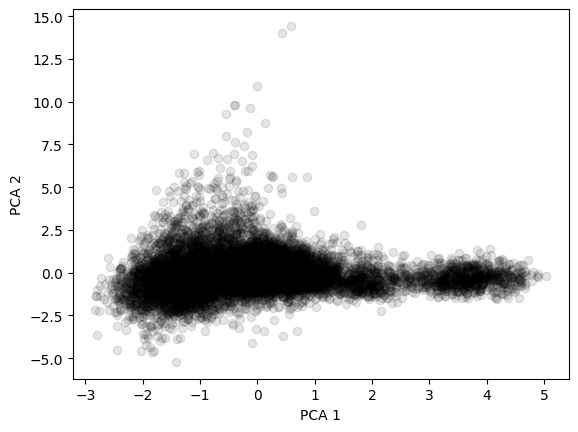

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X = StandardScaler().fit_transform(churn_num)

pca = PCA(n_components=2)
principalComp = pca.fit_transform(X)

PCA_components = pd.DataFrame(principalComp)

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


#### Search for variance optimization of pca

([<matplotlib.axis.XTick at 0x23c59470850>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

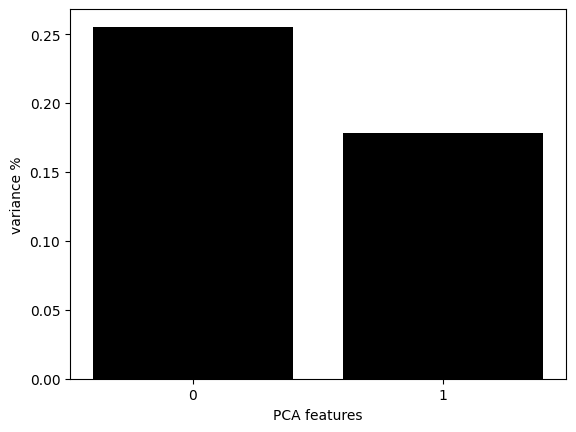

In [101]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

## DataFrame to add cluster column

In [102]:
churn_comp = pd.read_csv('../Data/cleaned_df.csv')
churn_comp.head()

,Unnamed: 0,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,Existing Customer,40,F,4,High School,0,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### Clustering model (Kmeans)

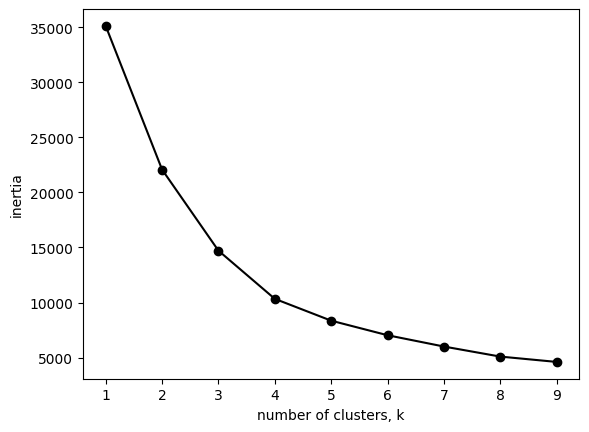

In [103]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,n_init=10)
    
    # Fit model to samples
    model.fit(PCA_components)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

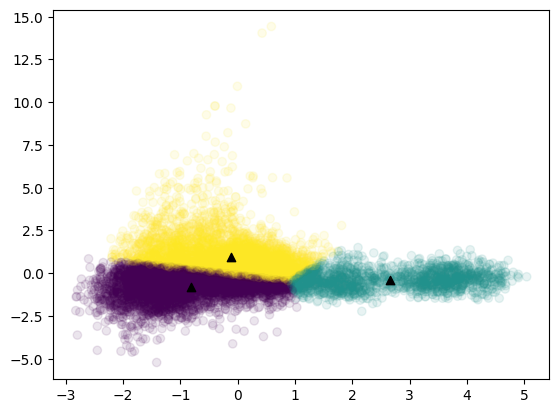

In [104]:
PCA_components.columns = PCA_components.columns.astype(str)
# fitting mmodel
model = KMeans(n_clusters=3,n_init=10,init='k-means++').fit(PCA_components)

# adding cluster col to df
cluster_labels = pd.Series(model.labels_, name='cluster')
churn_comp = churn_comp.join(cluster_labels.to_frame())
churn = churn.join(cluster_labels.to_frame())
# plotting results
plt.scatter(PCA_components["0"], PCA_components["1"], alpha=.1, c=cluster_labels)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
 marker='^', color='black')

churn_comp.to_csv('clusters.csv')

### % of attrition per clusters

In [105]:
cluster = churn.groupby('cluster')['Attrition_Flag'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
cluster

cluster  Attrition_Flag
0        2                 70.1%
         1                 29.9%
1        2                 91.9%
         1                  8.1%
2        2                 94.8%
         1                  5.2%
Name: Attrition_Flag, dtype: object

### Test of DBSCAN  algo ( not concluant )

In [106]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics


db = DBSCAN(eps=0.8, min_samples=2).fit(PCA_components.iloc[:,:3])
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 1


In [107]:
cluster_db = pd.Series(db.labels_, name='cluster_db')
churn = churn.join(cluster_db.to_frame())
print(churn['cluster_db'].value_counts())

 0    10120
 1        4
 2        2
-1        1
Name: cluster_db, dtype: int64


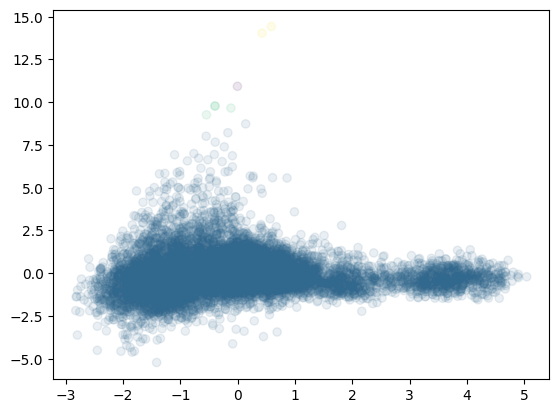

In [108]:
plt.scatter(PCA_components["0"], PCA_components["1"], alpha=.1, c=cluster_db)